# Modeling Lake Thermal Stratification

Note: For proper running, have the correct folder structure set up. This path needs to exist in your Drive

```
drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/
```
Ideally, a `data` and `output` folder should be in `Project 2` as well. 

Training the models takes some time, so to see the results that we have gotten, the shared folder containing `main.ipynb` has an existing `output` folder with our results. We recommend copying those results into your own `ouput` folder to generate the right plots. In fact, it is probably best practice to just copy the entire contents of `Project 2 ` (the shared folder) for ease of running.

## Motivation

In the paper, there were various ways the model was tested, including, but not limited to: restricting the training data to certain months, restricting the training data by size, and extending the model to other lake systems. As we saw, the model’s RMSE was significantly reduced across all testing schemas. However, LSTM models can become especially computationally heavy as layers, epochs, and data set sizes increase. So we'd like to improve the original model so that our new model would have faster speed while keeping a good performance. Based on this idea, a new evaluation method -- computation speed -- is introduced in our project.

Another way to speed up/simplify the model is to train it on less data. One novel approach we took to do this was to train models with while neglecting the lower depths. We then want to observe to see if our depth-limited model can capture the whole depth profile as well as the original while only being trained with a piece of it. 

To achieve our goal, we planed to modify the original model in two directions and finally combine them together. One is to adjust the optimizer in the machine learning model, another is to find an optimal partial training depth that still allows for the capturing of the entire depth profile in its predictions.

# Part 0. Setup Workspace

In [13]:
#@title Install packages
%%capture
!pip3 install sciencebasepy
!pip3 install opencv-python

In [14]:
#@title Import packages
import os, random, warnings
import numpy as np
import pandas as pd
import datetime
import torch
import cv2
import re
import matplotlib.pyplot as plt
import sciencebasepy
import urllib.request
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
from sklearn import preprocessing
from urllib.request import urlopen
from zipfile import ZipFile
import time

In [15]:
#@title Mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#@title  check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [17]:
#@title Set data directory - for evaluation, need to have these folders created in your own drive
data_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Data/'
output_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Output/'
if not os.path.isdir(data_dir): os.mkdir(data_dir) ## create the folder
if not os.path.isdir(output_dir): os.mkdir(output_dir) ## create the folder

In [18]:
#@title Download data
if os.listdir(data_dir) == []: ## data not downloaded yet
    print('Data folder is empty! Download the files now!')
    # set the url
    zipurl = 'https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/raw/main/Project-StarterCodes/Project2-PhysicsML/data/numpy_files.zip'
    # download the file from the URL
    zipresp = urlopen(zipurl)
    # create a new file on the hard drive
    tempzip = open(data_dir + 'numpy_files.zip', "wb")
    # write the contents of the downloaded file into the new file
    tempzip.write(zipresp.read())
    # close the newly-created file
    tempzip.close()
    # re-open the newly-created file with ZipFile()
    zf = ZipFile(data_dir + 'numpy_files.zip')
    # extract its contents into <extraction_path>
    # note that extractall will automatically create the path
    zf.extractall(path = data_dir)
    # close the ZipFile instance
    zf.close()
    print('Files all downloaded!')

# Part I: Define constants and functions for models, and load data for part II
Blurb about changes

In [44]:
#@title Set the algorithm configuration constants
# params for LSTM
epochs = 300 ## number of max training epochs
batch_size = 100 ## batch size in SGD, must be multiplication of n_depths
n_depths_train = 30 # change for top depths to train on
learning_rate = 1e-2 ## learning rate 
new_lr = 2e-2 # initial learning rate for dynamic lr
state_size = 7 ## dimension of hidden layers 
input_size = 9 ## matches with the data, last dimension of x
phy_size = 10 ## matches with the data, last dimension of phy
elam = 0.005 ## loss weight
patience = 3 ## patience in early stopping


# params for data transformation
npic = 10 #16 #40 number of pieces
N_sec = (npic-1)*2+1 ## number of segments (overlapped)
n_depths = 50 ## matches with data, first dimension of x, also = len(depth_areas)
ec_threshold = 24
ec_threshold_layer = 48
depth_areas = torch.Tensor([
        39865825,38308175,38308175,35178625,35178625,33403850,31530150,31530150,30154150,30154150,29022000,
        29022000,28063625,28063625,27501875,26744500,26744500,26084050,26084050,25310550,24685650,24685650,
        23789125,23789125,22829450,22829450,21563875,21563875,20081675,18989925,18989925,17240525,17240525,
        15659325,14100275,14100275,12271400,12271400,9962525,9962525,7777250,7777250,5956775,4039800,4039800,
        2560125,2560125,820925,820925,216125]).to(device)
depth_areas_train = depth_areas[:n_depths_train]

In [45]:
#@title Define functions for calculating ec loss
def transformTempToDensity(temp):
    # converts temperature to density
    # parameter:
        # @temp: single value or array of temperatures to be transformed
    densities = 1000 * (1 - ((temp + 288.9414) * (temp - 3.9863)**2) / (508929.2 * (temp + 68.12963)))
    return densities

def calculate_lake_energy(temps, densities, depth_areas):
    # calculate the total energy of the lake for every timestep
    # sum over all layers the (depth cross-sectional area)*temp*density*layer_height)
    # then multiply by the specific heat of water 
    dz = 0.5 # thickness for each layer, hardcoded for now
    cw = 4186 # specific heat of water
    depth_areas = torch.reshape(depth_areas, (-1, 1))
    energy = torch.sum(depth_areas * temps * densities * dz * cw, axis=0)
    return energy

def calculate_lake_energy_deltas(energies, combine_days, surface_area):
    # given a time series of energies, compute and return the differences
    # between each time step, or time step interval (parameter @combine_days)
    # as specified by parameter @combine_days
    time = 86400 #seconds per day
    energy_deltas = (energies[1:] - energies[:-1]) / (time * surface_area)
    return energy_deltas

def calculate_vapour_pressure_saturated(temp):
    # returns in miilibars
    # Converted pow function to exp function workaround pytorch not having autograd implemented for pow
    exponent = (9.28603523 - (2332.37885 / (temp + 273.15))) * np.log(10)
    return torch.exp(exponent)

def calculate_vapour_pressure_air(rel_hum, temp):
    rh_scaling_factor = 1
    return rh_scaling_factor * (rel_hum / 100) * calculate_vapour_pressure_saturated(temp)


def calculate_wind_speed_10m(ws, ref_height = 2.):
    # from GLM code glm_surface.c
    c_z0 = torch.tensor(0.001) #default roughness
    return ws * (torch.log(10.0 / c_z0) / torch.log(ref_height / c_z0))

def calculate_air_density(air_temp, rh):
    # returns air density in kg / m^3
    # equation from page 13 GLM/GLEON paper(et al Hipsey)
    # Ratio of the molecular (or molar) weight of water to dry air
    mwrw2a = 18.016 / 28.966
    c_gas = 1.0e3 * 8.31436 / 28.966

    # atmospheric pressure
    p = 1013. #mb

    # water vapor pressure
    vapPressure = calculate_vapour_pressure_air(rh, air_temp)

    # water vapor mixing ratio (from GLM code glm_surface.c)
    r = mwrw2a * vapPressure / (p - vapPressure)
    return (1.0 / c_gas * (1 + r)/(1 + r / mwrw2a) * p / (air_temp + 273.15)) * 100

def calculate_heat_flux_sensible(surf_temp, air_temp, rel_hum, wind_speed):
    # equation 22 in GLM/GLEON paper(et al Hipsey)
    # GLM code ->  Q_sensibleheat = -CH * (rho_air * 1005.) * WindSp * (Lake[surfLayer].Temp - MetData.AirTemp);
    # calculate air density 
    rho_a = calculate_air_density(air_temp, rel_hum)

    # specific heat capacity of air in J/(kg*C)
    c_a = 1005.

    # bulk aerodynamic coefficient for sensible heat transfer
    c_H = 0.0013

    # wind speed at 10m
    U_10 = calculate_wind_speed_10m(wind_speed)
    return -rho_a * c_a * c_H * U_10 * (surf_temp - air_temp)

def calculate_heat_flux_latent(surf_temp, air_temp, rel_hum, wind_speed):
    # equation 23 in GLM/GLEON paper(et al Hipsey)
    # GLM code-> Q_latentheat = -CE * rho_air * Latent_Heat_Evap * (0.622/p_atm) * WindSp * (SatVap_surface - MetData.SatVapDef)
    # where,         SatVap_surface = saturated_vapour(Lake[surfLayer].Temp);
    #                rho_air = atm_density(p_atm*100.0,MetData.SatVapDef,MetData.AirTemp);
    # air density in kg/m^3
    rho_a = calculate_air_density(air_temp, rel_hum)

    # bulk aerodynamic coefficient for latent heat transfer
    c_E = 0.0013

    # latent heat of vaporization (J/kg)
    lambda_v = 2.453e6

    # wind speed at 10m height
    # U_10 = wind_speed
    U_10 = calculate_wind_speed_10m(wind_speed)
    # 
    # ratio of molecular weight of water to that of dry air
    omega = 0.622

    # air pressure in mb
    p = 1013.

    e_s = calculate_vapour_pressure_saturated(surf_temp)
    e_a = calculate_vapour_pressure_air(rel_hum, air_temp)
    return -rho_a * c_E * lambda_v * U_10 * (omega / p) * (e_s - e_a)

def calculate_energy_fluxes(phys, surf_temps, combine_days):    
    e_s = 0.985 # emissivity of water, given by Jordan
    alpha_sw = 0.07 # shortwave albedo, given by Jordan Read
    alpha_lw = 0.03 # longwave, albeda, given by Jordan Read
    sigma = 5.67e-8 # Stefan-Baltzmann constant
    R_sw_arr = phys[:-1,2] + (phys[1:,2] - phys[:-1,2]) / 2
    R_lw_arr = phys[:-1,3] + (phys[1:,3] - phys[:-1,3]) / 2
    R_lw_out_arr = e_s * sigma * (torch.pow(surf_temps[:] + 273.15, 4))
    R_lw_out_arr = R_lw_out_arr[:-1] + (R_lw_out_arr[1:] - R_lw_out_arr[:-1]) / 2

    air_temp = phys[:-1,4] 
    air_temp2 = phys[1:,4]
    rel_hum = phys[:-1,5]
    rel_hum2 = phys[1:,5]
    ws = phys[:-1, 6]
    ws2 = phys[1:,6]
    t_s = surf_temps[:-1]
    t_s2 = surf_temps[1:]
    E = calculate_heat_flux_latent(t_s, air_temp, rel_hum, ws)
    H = calculate_heat_flux_sensible(t_s, air_temp, rel_hum, ws)
    E2 = calculate_heat_flux_latent(t_s2, air_temp2, rel_hum2, ws2)
    H2 = calculate_heat_flux_sensible(t_s2, air_temp2, rel_hum2, ws2)
    E = (E + E2) / 2
    H = (H + H2) / 2
    fluxes = (R_sw_arr[:-1] * (1-alpha_sw) + R_lw_arr[:-1] * (1-alpha_lw) - R_lw_out_arr[:-1] + E[:-1] + H[:-1])
    return fluxes

def calculate_ec_loss(inputs, outputs, phys, depth_areas, n_depths, ec_threshold, combine_days=1):
    # description: calculates energy conservation loss
    # parameters: 
        # @inputs: features
        # @outputs: labels
        # @phys: features(not standardized) of sw_radiation, lw_radiation, etc
        # @ labels modeled temp (will not used in loss, only for test) !!! DO NOT MODIFY THIS LINE !!!
        # @depth_areas: cross-sectional area of each depth
        # @n_depths: number of depths
        # @use_gpu: gpu flag
        # @combine_days: how many days to look back to see if energy is conserved
    #*********************************************************************************
    n_sets = int(inputs.shape[0] / n_depths)
    densities = transformTempToDensity(outputs)
    diff_per_set_r = torch.empty(n_sets) 
    for i in range(n_sets):
        # loop through sets of n_depths
        # indices
        start_index = i * n_depths
        end_index = (i + 1) * n_depths
        # calculate lake energy for each timestep
        lake_energies = calculate_lake_energy(outputs[start_index:end_index, :], densities[start_index:end_index, :], depth_areas)
        # calculate energy change in each timestep
        lake_energy_deltas = calculate_lake_energy_deltas(lake_energies, combine_days, depth_areas[0])
        lake_energy_deltas = lake_energy_deltas[1:]
        # calculate sum of energy flux into or out of the lake at each timestep
        lake_energy_fluxes = calculate_energy_fluxes(phys[start_index, :, :], outputs[start_index, :], combine_days)
        ### can use this to plot energy delta and flux over time to see if they line up
        diff_vec = torch.abs(lake_energy_deltas - lake_energy_fluxes) 
        tmp_mask = 1 - phys[start_index+1, 1:-1, 9] 
        tmp_loss = torch.mean(diff_vec * tmp_mask)
        diff_per_set_r[i] = tmp_loss 
    diff_per_set = torch.clamp(diff_per_set_r - ec_threshold, min=0, max=999999)
    return torch.mean(diff_per_set), diff_vec, diff_per_set_r, diff_per_set 


In [46]:
#@title Define LSTM
class LSTMnet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTMnet, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1)
        return out

In [47]:
#@title Define functions for deep learning
def weighted_rmse_loss(input, target, weight):
    # defined weighted rmse loss
    # used in model training
    return torch.sqrt(torch.sum(weight * (input - target) ** 2) / torch.sum(weight))

def batch_sample_generator(size_list, batch_size):
    ## create advanced batches for training-val-test
    ## each batch should match with depth_areas for calculating ec_loss
    n_batch = int(size_list / batch_size)
    n_remain = size_list % batch_size
    batch_sampler = [list(range(i * batch_size, i * batch_size + batch_size)) for i in range(n_batch)]
    if n_remain > 0:
        batch_sampler += [list(range(n_batch * batch_size, n_batch * batch_size + n_remain))]
    return batch_sampler

def train(model, epochs, optimizer, train_loader, valid_loader, early_stopping=True):
    the_last_loss = 100
    trigger_times = 0
    tr_loss = []
    for i in range(epochs):
        #print('This is epoch ' + str(i + 1))
        for batch, (x, y, m, p) in enumerate(train_loader):
            model.train()
            size = len(train_loader.dataset)
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)
            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas,
                                        n_depths,
                                        ec_threshold,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print output
            '''
            loss_track, current = loss.item(), batch * len(x)
            if batch%5 == 0:
                print("BatLoss = " + "{:.4f}".format(loss) + \
                    ", Rc = " + "{:.4f}".format(loss_1) + \
                    ", Ec = " + "{:.4f}".format(loss_2) + \
                    f'[{current:>5d}/{size:>5d}]')
            '''
        the_current_loss = val_test(model, valid_loader)
        tr_loss.append(the_current_loss)
        # Early stopping
        if early_stopping:
            #the_current_loss = val_test(model, valid_loader)
            #print('The current loss:', the_current_loss)
            if the_current_loss > the_last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    #print('Early stopping!\nStart to test process.')
                    return model, (i+1), tr_loss
            else:
                trigger_times = 0 ## reset trigger time to 0
                the_last_loss = the_current_loss
   
    return model, epochs, tr_loss
        

def train_with_scheduler(model, epochs, optimizer, scheduler, train_loader, valid_loader, early_stopping=True):
    the_last_loss = 100
    trigger_times = 0
    tr_loss = []
    for i in range(epochs):
        #print('This is epoch ' + str(i + 1))
        #running_loss = 0
        for batch, (x, y, m, p) in enumerate(train_loader):
            model.train()
            size = len(train_loader.dataset)
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)
            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas,
                                        n_depths,
                                        ec_threshold,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            #running_loss += loss.item()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        the_current_loss = val_test(model, valid_loader)
        scheduler.step(the_current_loss)
        #print('The current learning rate:', optimizer.param_groups[0]['lr'])
        tr_loss.append(the_current_loss)

        # Early stopping
        if early_stopping:
            #the_current_loss = val_test(model, valid_loader)
            #print('The current loss:', the_current_loss)
            if the_current_loss > the_last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    #print('Early stopping!\nStart to test process.')
                    return model, (i+1), tr_loss
            else:
                trigger_times = 0 ## reset trigger time to 0
                the_last_loss = the_current_loss
    return model, epochs, tr_loss
        

def val_test(model, data_loader):
    # Settings
    model.eval()

    loss_total = 0
    # make predictions on validation/test data
    with torch.no_grad():
        for batch, (x, y, m, p) in enumerate(data_loader):
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)

            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas,
                                        n_depths,
                                        ec_threshold,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            loss_total += loss.item()
    return loss_total / len(data_loader)

# Training with reduced layers (for later)
def train_layer(model, epochs, optimizer, scheduler, train_loader, valid_loader, early_stopping=True):
    the_last_loss = 100
    trigger_times = 0
    tr_loss = []
    for i in range(epochs):
        for batch, (x, y, m, p) in enumerate(train_loader):
            model.train()
            size = len(train_loader.dataset)
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)
            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas_train,
                                        n_depths_train,
                                        ec_threshold_layer,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            #running_loss += loss.item()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        the_current_loss = val_test_layer(model, valid_loader)
        scheduler.step(the_current_loss)
        #print('The current learning rate:', optimizer.param_groups[0]['lr'])
        tr_loss.append(the_current_loss)

        # Early stopping
        if early_stopping:
            #the_current_loss = val_test_layer(model, valid_loader)
            #print('The current loss:', the_current_loss)
            if the_current_loss > the_last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    #print('Early stopping!\nStart to test process.')
                    return model, (i+1), tr_loss
            else:
                trigger_times = 0 ## reset trigger time to 0
                the_last_loss = the_current_loss
    return model, epochs, tr_loss

def val_test_layer(model, data_loader):
    # Settings
    model.eval()

    loss_total = 0
    # make predictions on validation/test data
    with torch.no_grad():
        for batch, (x, y, m, p) in enumerate(data_loader):
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)

            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas_train,
                                        n_depths_train,
                                        ec_threshold_layer,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            loss_total += loss.item()
    return loss_total / len(data_loader)

In [48]:
#@title Load data
# load data
x_full = np.load(data_dir + '/processed_features.npy') #standardized inputs
x_raw_full = np.load(data_dir + '/features.npy') #raw inputs
diag_full = np.load(data_dir + '/diag.npy') 
label_full = np.load(data_dir + '/labels.npy') #simulated lake temperatures

# process data
mask_full = np.ones(label_full.shape) # no missing values to mask for simulated data
phy_full = np.concatenate((x_raw_full[:,:,:(-2)], diag_full), axis=2) 
## phy: 4-air temp, 5-rel hum, 6-wind speed, 9-ice flag

# print the shape
print(f"The shape of x_full is {np.shape(x_full)}")
print(f"The shape of x_raw_full is {np.shape(x_raw_full)}")
print(f"The shape of diag_full is {np.shape(diag_full)}")
print(f"The shape of label is {np.shape(label_full)}")

# train-val split
## in model pretraining, we use validation set to find the best number of steps 
## Here we use equal size for train-val split
## They can be of different sizes by using different n_steps 
N = np.shape(x_full)[1] # the total number of samples
idx_tr, idx_va, idx_te = (int(N/3), int(N/3*2), N)


## training
x_tr = x_full[:, :idx_tr]
y_tr = label_full[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask_full[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label_full[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask_full[:, idx_tr:idx_va]

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])


for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

# print the shape
print(f"The shape of x_train is {np.shape(x_train)}")
print(f"The shape of y_train is {np.shape(y_train)}")
print(f"The shape of p_train is {np.shape(p_train)}")
print(f"The shape of m_train is {np.shape(m_train)}")


The shape of x_full is (50, 12691, 9)
The shape of x_raw_full is (50, 12691, 9)
The shape of diag_full is (50, 12691, 3)
The shape of label is (50, 12691)
The shape of x_train is (950, 423, 9)
The shape of y_train is (950, 423)
The shape of p_train is (950, 423, 10)
The shape of m_train is (950, 423)


In [49]:
#@title Create data loaders for pretraining with simulated data
train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

In [50]:
#@title Load data for retraining with observed data
# load data ---------------------------------------------------------------
x_full = np.load(data_dir + 'processed_features.npy') # input data
x_raw_full = np.load(data_dir + 'features.npy') # raw input data
diag_full = np.load(data_dir + 'diag.npy')
label = np.load(data_dir + 'Obs_temp.npy') # real observation data
mask = np.load(data_dir + 'Obs_mask.npy') # flags of missing values
phy_full = np.concatenate((x_raw_full[:,:,:-2], diag_full), axis = 2) #physics variables

# train-val-test split
## Here we use equal size for train-val-test split
## They can be of different sizes by using different n_steps 
idx_tr, idx_va, idx_te = (4000, 8000, 12000)
print(idx_tr, idx_va, idx_te)

## training
x_tr = x_full[:, :idx_tr]
y_tr = label[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask[:, idx_tr:idx_va]


## testing
x_te = x_full[:, idx_va:idx_te]
y_te = label[:, idx_va:idx_te]
p_te = phy_full[:, idx_va:idx_te]
m_te = mask[:, idx_va:idx_te]

# sparsify mask

s_perc =0.99 #0.002 #0.2#0.4 #0.6 #0.8
## training
m_tr = np.reshape(m_tr, (-1, 1))
loc_tr = np.random.choice(np.arange(m_tr.shape[0]), replace=False, size=int(m_tr.shape[0] * (1-s_perc)))
m_tr[loc_tr, 0] = 0.0
## validation
m_va = np.reshape(m_va, (-1, 1))
loc_va = np.random.choice(np.arange(m_va.shape[0]), replace=False, size=int(m_va.shape[0] * (1-s_perc)))
m_va[loc_va, 0] = 0.0
## reshaping
m_tr = np.reshape(m_tr, (50, -1))
m_va = np.reshape(m_va, (50, -1))

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])

x_test = np.zeros([n_depths * N_sec, n_steps, input_size])
y_test = np.zeros([n_depths * N_sec, n_steps])
p_test = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_test = np.zeros([n_depths * N_sec, n_steps])

for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]
    x_test[(i-1)*n_depths:(i*n_depths)] = x_te[:, r_1:r_2]
    y_test[(i-1)*n_depths:(i*n_depths)] = y_te[:, r_1:r_2]
    p_test[(i-1)*n_depths:(i*n_depths)] = p_te[:, r_1:r_2]
    m_test[(i-1)*n_depths:(i*n_depths)] = m_te[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

4000 8000 12000


In [51]:
#@title Create data loaders to retrain with observed data
train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

test_data = TensorDataset(torch.from_numpy(x_test), 
                           torch.from_numpy(y_test), 
                           torch.from_numpy(m_test),
                           torch.from_numpy(p_test))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader_obs = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader_obs = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
te_loader_obs = DataLoader(test_data, batch_sampler=batch_sample_generator(len(test_data), batch_size))
fu_loader_obs = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

# Part II: Comparing optimizer effeciencies
In part II, we present the final results from analyzing different optimizer choices. 

To compare their performance of different optimizer, we created six models with different optimizer. Here are two graphs that compare the test loss and running time of the six models. For the intermediate steps involved in determining our choice of optimizer, refer to 
[DynamicLR&Optimizer](https://colab.research.google.com/drive/1w4GfctH9CSgxqXDMkf_Q1lcmA87gFndh?usp=sharing)

![picture](https://drive.google.com/uc?id=1NpgQKm34oaM-lkVp-0zq6Hme6FnvQsIA)
![picture](https://drive.google.com/uc?id=1qS9Wu9r4FrtzcJNtjPwX783fJV3Us_Mq)

Testing the optimizers serval times, we found the optimizers with dynamic learning rate are faster than the optimizers with fixed learning rate. What's more, the optimizers with dynamic learning rate have a good performance. Among all three algorithms -- Adam, SGD, and AdamW -- we tested, SGD usually has a better performance in test loss.So we choose to use the optimizer with SGD algorithm and dynamic learning rate in our final model.

In this section we build, train, and compare our selected model with the original physics guided LSTM (PG LSTM) model provided in the starter code. 

Our evaluation metric for part II is comparing the average test loss between these models, along with their runtime. 

We will train these models multiple times and save the losses and runtimes to compare at the end. This section takes a long time, so skip if you want to see the additional depth test right away.

In [52]:
#@title Training/testing two models multiple times to get losses and training times - SKIP IF DON'T WANT TO RUN A LONG TIME
run = 0
test_losses = []
train_times = []
test_losses_new = []
train_times_new = []
while run <1: # change this value for more or less data points
  run += 1
  '''Pretrain with early stopping'''
  # original PG LSTM model
  net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
  optimizer_adam_fixlr = optim.Adam(net.parameters(), lr=learning_rate)
  t0 = time.time()
  net_adam_fixlr, best_epoch_adam_fixlr, loss_adam_fixlr = train(net, epochs, optimizer_adam_fixlr, tr_loader, va_loader)
  t1_ori = time.time()-t0

  # new model
  net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
  optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
  scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
  t0 = time.time()
  net_sgd_dynlr, best_epoch_sgd_dynlr, loss_sgd_dynlr = train_with_scheduler(net, epochs, optimizer_sgd_dynlr, scheduler_sgd, tr_loader, va_loader)
  t1_new = time.time()-t0

  '''Retrain with best parameters'''
  # original model
  net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
  optimizer_adam_fixlr = optim.Adam(net.parameters(), lr=learning_rate)
  t0 = time.time()
  net_adam_fixlr, _, loss_adam_fixlr = train(net, best_epoch_adam_fixlr, optimizer_adam_fixlr, fu_loader, fu_loader, early_stopping=False)
  t2_ori = t1_ori + time.time()-t0

  # new model
  net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
  optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
  scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
  t0 = time.time()
  net_sgd_dynlr, _, loss_sgd_dynlr = train_with_scheduler(net, best_epoch_sgd_dynlr, optimizer_sgd_dynlr, scheduler_sgd, fu_loader, fu_loader, early_stopping=False)
  t2_new = t1_new + time.time()-t0

  #Save the trained model in the output folder for future use. 
  torch.save(net_adam_fixlr, output_dir + 'adam_fixlr_model_pretrain.pt')
  torch.save(net_sgd_dynlr, output_dir + 'sgd_dynlr_model_pretrain.pt')

  '''Retrain with observed data (early stopping)'''
  # original model
  net = torch.load(output_dir + 'adam_fixlr_model_pretrain.pt').to(device)
  optimizer_adam_fixlr = optim.Adam(net.parameters(), lr=learning_rate)
  t0 = time.time()
  net_adam_fixlr, best_epoch_adam_fixlr, loss_adam_fixlr = train(net, epochs, optimizer_adam_fixlr, tr_loader_obs, va_loader_obs)
  t3_ori = t2_ori + time.time()-t0

  # new model
  net = torch.load(output_dir + 'sgd_dynlr_model_pretrain.pt').to(device)
  optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
  scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
  t0 = time.time()
  net_sgd_dynlr, best_epoch_sgd_dynlr, loss_sgd_dynlr = train_with_scheduler(net, epochs, optimizer_sgd_dynlr, scheduler_sgd, tr_loader_obs, va_loader_obs)
  t3_new = t2_new + time.time()-t0

  '''Retrain with observed data and best parameters'''
  #original model
  net = torch.load(output_dir + 'adam_fixlr_model_pretrain.pt').to(device)
  optimizer_adam_fixlr = optim.Adam(net.parameters(), lr=learning_rate)
  t0 = time.time()
  net_adam_fixlr, _, loss_adam_fixlr = train(net, best_epoch_adam_fixlr, optimizer_adam_fixlr, fu_loader_obs, fu_loader_obs, early_stopping=False)
  t4_ori = t3_ori + time.time()-t0

  # new model
  net = torch.load(output_dir + 'sgd_dynlr_model_pretrain.pt').to(device)
  optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
  scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
  t0 = time.time()
  net_sgd_dynlr, _, loss_sgd_dynlr = train_with_scheduler(net, best_epoch_sgd_dynlr, optimizer_sgd_dynlr, scheduler_sgd, fu_loader_obs, fu_loader_obs, early_stopping=False)
  t4_new = t3_new + time.time()-t0

  # Evaluate
  print(f"Run {run}")
  net_adam_fixlr.eval()
  test_losses.append(val_test(net_adam_fixlr, te_loader_obs))
  train_times.append(t4_ori)
  print("The test loss for the original model: ",val_test(net_adam_fixlr, te_loader_obs))
  print("The training time for the original model: ",t4_ori)

  net_sgd_dynlr.eval()
  test_losses_new.append(val_test(net_sgd_dynlr, te_loader_obs))
  train_times_new.append(t4_new)
  print("The test loss for our new model: ",val_test(net_sgd_dynlr, te_loader_obs))
  print("The training time for our new model: ",t4_new)

  torch.save(net_adam_fixlr, output_dir + 'adam_fixlr_model_finetune.pt')
  torch.save(net_sgd_dynlr, output_dir + 'sgd_dynlr_model_finetune.pt')

Run 1
The test loss for the original model:  1.4373022267005149
The training time for the original model:  187.67142176628113
The test loss for our new model:  1.4119257686182776
The training time for our new model:  103.79242300987244


In [53]:
#@title Save losses and times, for when doing a large loop. DON'T RUN IF USING SMALL LOOP
#np.save(output_dir + 'test_losses.npy',np.array(test_losses))
#np.save(output_dir + 'test_losses_new.npy',np.array(test_losses_new))
#np.save(output_dir + 'train_times.npy',np.array(train_times))
#np.save(output_dir + 'train_times_new.npy',np.array(train_times_new))

Generally, the SGD seems to run faster while maintaining a test loss similar to that of the original model. There is definitely some variability depending on the device this script is run on, but overall from our experience, this seems to be the trend. Here is a boxplot of times and losses from 10 different runs:

[Text(0, 0, 'Original Model (Adam, fixed LR)'),
 Text(0, 0, 'SGD model with dynamic LR')]

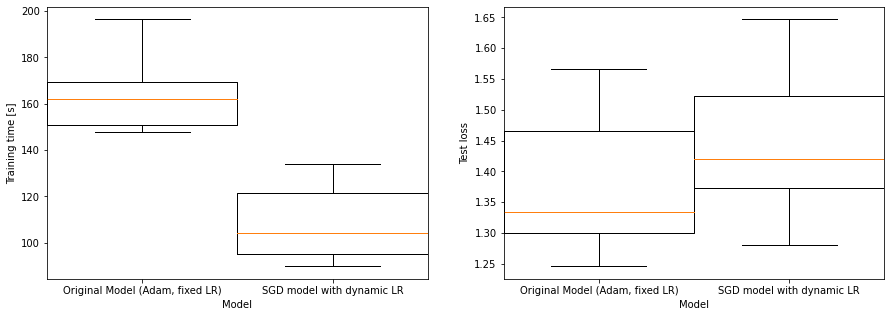

In [54]:
#@title Visualize the times/losses
test_losses = np.load(output_dir + 'test_losses.npy')
test_losses_new = np.load(output_dir + 'test_losses_new.npy')
train_times = np.load(output_dir + 'train_times.npy')
train_times_new = np.load(output_dir + 'train_times_new.npy')
fig, axs = plt.subplots(1, 2,figsize=(15,5))

axs[0].boxplot(train_times,positions=[0],widths=1)
axs[0].boxplot(train_times_new,positions = [1],widths=1)
axs[0].set(ylabel="Training time [s]",xlabel="Model")
axs[0].set_xticklabels(["Original Model (Adam, fixed LR)","SGD model with dynamic LR"])

axs[1].boxplot(test_losses,positions=[0],widths=1)
axs[1].boxplot(test_losses_new,positions = [1],widths=1)
axs[1].set(ylabel="Test loss",xlabel="Model")
axs[1].set_xticklabels(["Original Model (Adam, fixed LR)","SGD model with dynamic LR"])

Here we see that although there is a small increase in test loss, our new model is significantly faster than the existing one. Next, we aim to make it even faster with a similar level of accuracy by training with a reduced amount of temperatures by depth. Some extra investigation of our multiple runs suggested that the variability in timing for the dynamic learning rate happens after the pretraining with the simulation data. Consequently, by training and validating with a smaller data set (from only using shallower depths), we can probably speed up the timing further. 

# Part III: Evaluating reduced temperature measurements along depth
One factor we wondered about is if the full depth temperature profile was needed to train the data. Some initial data analysis reveals that the temperatures at the bottom of Lake Mendota vary a lot less than the surface temperatures. We visualize this with our simulated temperatures.

Text(0.5, 1.0, 'Temporal standard deviation of temperature from GLM simulation')

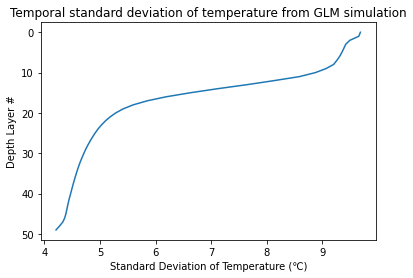

In [34]:
#@title Investigating variability of simulated temperatures
plt.plot(np.sqrt(np.var(label_full,axis=1)),np.arange(0,50))
plt.gca().invert_yaxis()
plt.ylabel("Depth Layer #")
plt.xlabel("Standard Deviation of Temperature (℃)")
plt.title("Temporal standard deviation of temperature from GLM simulation")

We assume that this lack of variation is due to a smaller influence of mixing at the bottom - i.e. the winds at the surface have a much smaller inflence on the temperatures near the bottom. As a result, we chose to neglect these temperatures in our training and validation process in our new model to see how it impacts prediction. Since there's less mixing at the bottom, we assume that this does not contribute as much to the energy conservation of the lake. We still increase the EC threshold variable to account for possible energies missing from the neglected lower layers, since as shown aboce, the variations at the bottom aren't completely zero. 

To evaluate our improved model that is trained on less data, we will compare it with the model that trains on the entire dataset. 

Since from the above plot the standard deviation of temperature drops significantly after around depth layer 30, we will choose that as our cutoff layer. 

We start by doing the usual pretraining. The pretraining is the same as before since it is done on simulated data, so we can still include the whole depth profile. Our depth restrictions are just for the measured temperatures.

In [55]:
#@title Load data/initialize data loaders for pretraining
# load data
x_full = np.load(data_dir + '/processed_features.npy') #standardized inputs
x_raw_full = np.load(data_dir + '/features.npy') #raw inputs
diag_full = np.load(data_dir + '/diag.npy') 
label_full = np.load(data_dir + '/labels.npy') #simulated lake temperatures

# process data
mask_full = np.ones(label_full.shape) # no missing values to mask for simulated data
phy_full = np.concatenate((x_raw_full[:,:,:(-2)], diag_full), axis=2) 
## phy: 4-air temp, 5-rel hum, 6-wind speed, 9-ice flag

# print the shape
print(f"The shape of x_full is {np.shape(x_full)}")
print(f"The shape of x_raw_full is {np.shape(x_raw_full)}")
print(f"The shape of diag_full is {np.shape(diag_full)}")
print(f"The shape of label is {np.shape(label_full)}")

# train-val split
## in model pretraining, we use validation set to find the best number of steps 
## Here we use equal size for train-val split
## They can be of different sizes by using different n_steps 
N = np.shape(x_full)[1] # the total number of samples
idx_tr, idx_va, idx_te = (int(N/3), int(N/3*2), N)


## training
x_tr = x_full[:, :idx_tr]
y_tr = label_full[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask_full[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label_full[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask_full[:, idx_tr:idx_va]

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])


for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

# print the shape
print(f"The shape of x_train is {np.shape(x_train)}")
print(f"The shape of y_train is {np.shape(y_train)}")
print(f"The shape of p_train is {np.shape(p_train)}")
print(f"The shape of m_train is {np.shape(m_train)}")

train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

The shape of x_full is (50, 12691, 9)
The shape of x_raw_full is (50, 12691, 9)
The shape of diag_full is (50, 12691, 3)
The shape of label is (50, 12691)
The shape of x_train is (950, 423, 9)
The shape of y_train is (950, 423)
The shape of p_train is (950, 423, 10)
The shape of m_train is (950, 423)


In [56]:
#@title Pretraining (as usual) - SKIP TO JUST SEE SAVED RESULTS
net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
t0 = time.time()
net_sgd_dynlr, best_epoch_sgd_dynlr, loss_sgd_dynlr = train_with_scheduler(net, epochs, optimizer_sgd_dynlr, scheduler_sgd, tr_loader, va_loader)
t1_new = time.time()-t0

net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
t0 = time.time()
net_sgd_dynlr, _, loss_sgd_dynlr = train_with_scheduler(net, best_epoch_sgd_dynlr, optimizer_sgd_dynlr, scheduler_sgd, fu_loader, fu_loader, early_stopping=False)
t2_new = t1_new + time.time()-t0
torch.save(net_sgd_dynlr, output_dir + 'sgd_dynlr_model_pretrain.pt')

In [57]:
#@title Load in reduced data for training and make data loaders

x_full = np.load(data_dir + 'processed_features.npy') # input data
x_raw_full = np.load(data_dir + 'features.npy') # raw input data
diag_full = np.load(data_dir + 'diag.npy')
label = np.load(data_dir + 'Obs_temp.npy') # real observation data
mask = np.load(data_dir + 'Obs_mask.npy') # flags of missing values
phy_full = np.concatenate((x_raw_full[:,:,:-2], diag_full), axis = 2) #physics variables

# train-val-test split
## Here we use equal size for train-val-test split
## They can be of different sizes by using different n_steps 
N = np.shape(x_full)[1] # the total number of samples
idx_tr, idx_va, idx_te = (int(N/3), int(N/3*2), N)
print(idx_tr, idx_va, idx_te)

## training
x_tr = x_full[:n_depths_train, :idx_tr]
y_tr = label[:n_depths_train, :idx_tr]
p_tr = phy_full[:n_depths_train, :idx_tr]
m_tr = mask[:n_depths_train, :idx_tr]
## validation
x_va = x_full[:n_depths_train, idx_tr:idx_va]
y_va = label[:n_depths_train, idx_tr:idx_va]
p_va = phy_full[:n_depths_train, idx_tr:idx_va]
m_va = mask[:n_depths_train, idx_tr:idx_va]

## testing
x_te = x_full[:, idx_va:idx_te]
y_te = label[:, idx_va:idx_te]
p_te = phy_full[:, idx_va:idx_te]
m_te = mask[:, idx_va:idx_te]

# sparsify mask

s_perc =0.99 #0.002 #0.2#0.4 #0.6 #0.8
## training
m_tr = np.reshape(m_tr, (-1, 1))
loc_tr = np.random.choice(np.arange(m_tr.shape[0]), replace=False, size=int(m_tr.shape[0] * (1-s_perc)))
m_tr[loc_tr, 0] = 0.0
## validation
m_va = np.reshape(m_va, (-1, 1))
loc_va = np.random.choice(np.arange(m_va.shape[0]), replace=False, size=int(m_va.shape[0] * (1-s_perc)))
m_va[loc_va, 0] = 0.0
## reshaping
m_tr = np.reshape(m_tr, (n_depths_train, -1))
m_va = np.reshape(m_va, (n_depths_train, -1))

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths_train * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths_train * N_sec, n_steps])
p_train = np.zeros([n_depths_train * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths_train * N_sec, n_steps])

x_val = np.zeros([n_depths_train * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths_train * N_sec, n_steps])
p_val = np.zeros([n_depths_train * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths_train * N_sec, n_steps])

x_test = np.zeros([n_depths * N_sec, n_steps, input_size])
y_test = np.zeros([n_depths * N_sec, n_steps])
p_test = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_test = np.zeros([n_depths * N_sec, n_steps])

for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths_train:(i*n_depths_train)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths_train:(i*n_depths_train)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths_train:(i*n_depths_train)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths_train:(i*n_depths_train)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths_train:(i*n_depths_train)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths_train:(i*n_depths_train)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths_train:(i*n_depths_train)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths_train:(i*n_depths_train)] = m_va[:, r_1:r_2]
    x_test[(i-1)*n_depths:(i*n_depths)] = x_te[:, r_1:r_2]
    y_test[(i-1)*n_depths:(i*n_depths)] = y_te[:, r_1:r_2]
    p_test[(i-1)*n_depths:(i*n_depths)] = p_te[:, r_1:r_2]
    m_test[(i-1)*n_depths:(i*n_depths)] = m_te[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)
print(f"The shape of x_f is {np.shape(x_f)}")
print(f"The shape of y_f is {np.shape(y_f)}")
print(f"The shape of p_f is {np.shape(p_f)}")
print(f"The shape of m_f is {np.shape(m_f)}")

train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

test_data = TensorDataset(torch.from_numpy(x_test), 
                           torch.from_numpy(y_test), 
                           torch.from_numpy(m_test),
                           torch.from_numpy(p_test))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))
batch_size_train = n_depths_train*2
tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size_train))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size_train))
te_loader = DataLoader(test_data, batch_sampler=batch_sample_generator(len(test_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size_train))

4230 8460 12691
The shape of x_f is (1140, 423, 9)
The shape of y_f is (1140, 423)
The shape of p_f is (1140, 423, 10)
The shape of m_f is (1140, 423)


In [58]:
#@title Retrain with filtered data - SKIP TO JUST SEE SAVED RESULTS
# pretrain for params
net = torch.load(output_dir + 'sgd_dynlr_model_pretrain.pt').to(device)
optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
t0 = time.time()
net_sgd_dynlr, best_epoch_sgd_dynlr, loss_sgd_dynlr = train_layer(net, epochs, optimizer_sgd_dynlr, scheduler_sgd, tr_loader, va_loader)
t3_new = t2_new + time.time()-t0

# retrain
net = torch.load(output_dir + 'sgd_dynlr_model_pretrain.pt').to(device)
optimizer_sgd_dynlr = optim.SGD(net.parameters(), lr=new_lr, momentum=0.9)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_dynlr, 'min', patience=2)
t0 = time.time()
net_sgd_dynlr, _, loss_sgd_dynlr = train_layer(net, best_epoch_sgd_dynlr, optimizer_sgd_dynlr, scheduler_sgd, fu_loader, fu_loader, early_stopping=False)
t4_new = t3_new + time.time()-t0

In [59]:
#@title Save model (if running training)
#torch.save(net, output_dir + f'model_finetune_{n_depths_train}_depths.pt')

In [60]:
#@title Check test loss
net = torch.load(output_dir + 'sgd_dynlr_model_pretrain.pt')
net.eval()
print('Test loss of pretraining model is:', val_test(net, te_loader))

net = torch.load(output_dir + f'model_finetune_{n_depths_train}_depths.pt').to(device)
net.eval()
print('Test loss of reduced model is:', val_test(net, te_loader))

Test loss of pretraining model is: 2.2663458288358322
Test loss of reduced model is: 1.5019534522469355


We see that the test loss of this depth-reduced-data-trained model is within the range of the regular test losses given by the variable learning rate model being trained on the whole data set. This loss is also a lot lower than the pretraining model.

In [61]:
#@title Process dates info
# load the dates information
dates_arr = np.load(data_dir + 'dates.npy')
dates_d = dates_arr.astype('M8[D]') ## transform the dates to date
dates_m = dates_arr.astype('M8[M]') ## transform the dates to date
dates_y = dates_arr.astype('M8[Y]') ## transform the dates to year
# load features
x_raw = np.load(data_dir + 'features.npy')
x_proc = np.load(data_dir + 'processed_features.npy')
# load the labels
label = np.load(data_dir + 'Obs_temp.npy')
print('Shape of labels:', label.shape)
# load the weight
weight = np.load(data_dir + 'Obs_mask.npy')
print('Shape of weight:', weight.shape)
print('Mean of weight:', np.mean(weight)) ## data is very sparse, 2% of the data are not nan
# filter the test set
label_test = label[:, idx_va:idx_te]
weight_test = weight[:, idx_va:idx_te]
dates_test_d = dates_d[idx_va:idx_te]
dates_test_m = dates_m[idx_va:idx_te]
dates_test_y = dates_y[idx_va:idx_te].astype(str)
print('Years available:', np.unique(dates_test_y))

Shape of labels: (50, 12691)
Shape of weight: (50, 12691)
Mean of weight: 0.020735954613505633
Years available: ['2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012'
 '2013' '2014']


We will be comparing this reduced depth model with the original model (Adam, fixed LR) from the starter script. RMSE errors are calculated below:

In [64]:
#@title Calculate errors
net = torch.load(output_dir + 'adam_fixlr_model_pretrain.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_pret = net(x).cpu().numpy()

label_pret = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_pret[:, r_1:r_2] = pred_pret[(i-1)*n_depths:(i*n_depths)].copy()
err_pret = label_test - label_pret

net = torch.load(output_dir + 'adam_fixlr_model_finetune.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_fine = net(x).cpu().numpy()

label_fine = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_fine[:, r_1:r_2] = pred_fine[(i-1)*n_depths:(i*n_depths)].copy()
err_fine = label_test - label_fine

net = torch.load(output_dir + f'model_finetune_{n_depths_train}_depths.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_fine_depth = net(x).cpu().numpy()

label_fine_depth = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_fine_depth[:, r_1:r_2] = pred_fine_depth[(i-1)*n_depths:(i*n_depths)].copy()
err_fine_depth = label_test - label_fine_depth

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

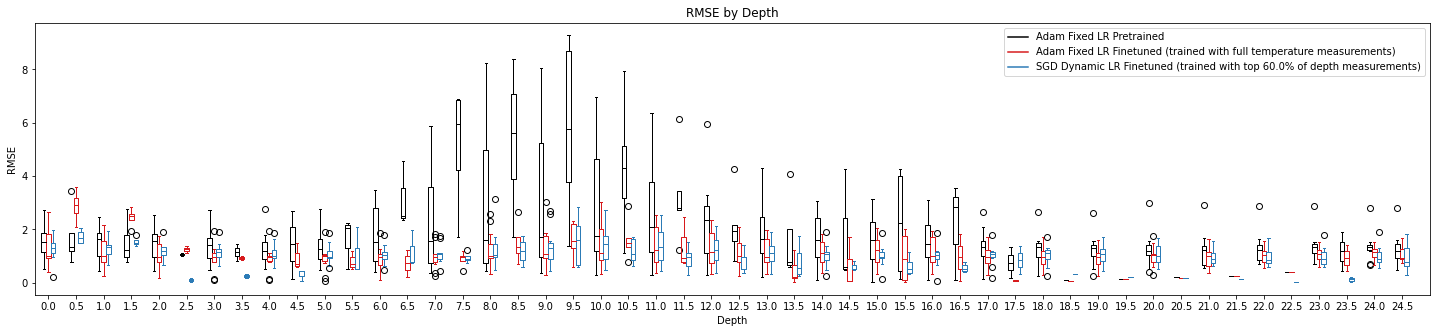

In [66]:
#@title Show RMS along depth
from torch import jit
dates_test_m_int = np.array([str(i)[-2:] for i in dates_test_m]).astype(int)

# visualizatin along different depths
depth_vec = x_raw[:, 0, 1]
RMSE_pret = []
RMSE_fine = []
RMSE_fine_depth = []

for i in range(len(depth_vec)):
    RMSE_pret_temp = []
    RMSE_fine_temp = []
    RMSE_fine_depth_temp = []

    for j in range(12):
        weight_m = weight_test[i, dates_test_m_int == j]
        if weight_m.sum() > 0:
            err_pret_m = err_pret[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_pret_m ** 2) / np.sum(weight_m))
            RMSE_pret_temp.append(RMSE_m)

            err_fine_m = err_fine[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_fine_m ** 2) / np.sum(weight_m))
            RMSE_fine_temp.append(RMSE_m)
            
            err_fine_depth_m = err_fine_depth[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_fine_depth_m ** 2) / np.sum(weight_m))
            RMSE_fine_depth_temp.append(RMSE_m)
    RMSE_pret.append(RMSE_pret_temp)
    RMSE_fine.append(RMSE_fine_temp)
    RMSE_fine_depth.append(RMSE_fine_depth_temp)

plt.figure(figsize=(25, 5))

bpl = plt.boxplot(RMSE_pret, positions=6*np.arange(len(depth_vec)) - 1, widths=1)
bpr = plt.boxplot(RMSE_fine, positions=6*np.arange(len(depth_vec)) , widths=1)
bpr_d = plt.boxplot(RMSE_fine_depth, positions=6*np.arange(len(depth_vec)) + 1, widths=1)

ticks = np.arange(50) / 2

# setting colors for each groups
def define_box_properties(plot_name, color_code, label):
	for k, v in plot_name.items():
		plt.setp(plot_name.get(k), color=color_code)
		
	# use plot function to draw a small line to name the legend.
	plt.plot([], c=color_code, label=label)
	plt.legend()

define_box_properties(bpl, '#000000', 'Adam Fixed LR Pretrained')
define_box_properties(bpr, '#D7191C', 'Adam Fixed LR Finetuned (trained with full temperature measurements)')
define_box_properties(bpr_d, '#2C7BB6', f'SGD Dynamic LR Finetuned (trained with top {100*n_depths_train/n_depths}% of depth measurements)')
plt.legend()
# set the x label values
plt.xticks(np.arange(0, len(depth_vec) * 6, 6), ticks)
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.xlim(-3, len(depth_vec) * 6)
plt.title('RMSE by Depth')
plt.show()


We see that our model is about the same accuracy in general as the orignal starter script model, even though it only trains on the top 60% of measured temperatures. Now for the overall RMSE between models:

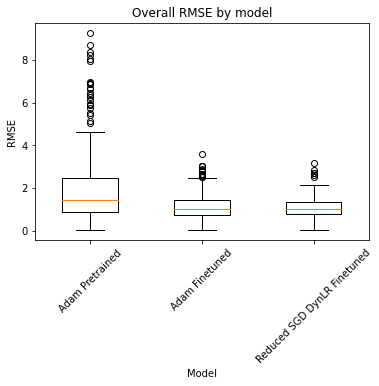

In [91]:
#@title Show overall RMSE

RMSE_pret_flat = list(np.concatenate(RMSE_pret).flat)
RMSE_fine_flat = list(np.concatenate(RMSE_fine).flat)
RMSE_fine_depth_flat = list(np.concatenate(RMSE_fine_depth).flat)
 
 
bpl = plt.boxplot(RMSE_pret_flat, positions = [0],widths=0.5)
bpr = plt.boxplot(RMSE_fine_flat, positions = [1], widths=0.5)
bpr_d = plt.boxplot(RMSE_fine_depth_flat, positions = [2], widths=0.5)
 
# set the x label values
plt.xticks([0,1,2], ['Adam Pretrained','Adam Finetuned','Reduced SGD DynLR Finetuned'],
           rotation=45)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Overall RMSE by model')
plt.show()

We see more clearly that our reduced model performs at around the same accuracy as the original model. In some runs, there is some variance, but in general, our model performs on par with the original model. Most notably, our model runs consistently faster than any of the models that are trained on the entire depths:

In [83]:
#@title Check timing of new model
print(f"Runtime for reduced depth model is: {t4_new}")

Runtime for reduced depth model is: 65.79361891746521


### Summary
Our reduced depth and variable learning rate model can allows for the prediction of lake temperatures at a much faster computational speed than the existing physics-guided LSTM model. It also does not need as much measured data to generate similarly accurate results. This offers a glimpse into how the predictive power of a physics guided deep learning model can not only predict temperatures over time, but perhaps over space as well. Some next steps would include reinvestigating the loss function to account for the neglection of basal layers, or using some kind of optimiser to determine minimal depths needed to attain a specific degree of accuracy in predictions.

## References
+ Read, J. S., Jia, X., Willard, J., Appling, A. P., Zwart, J. A., Oliver, S. K., ... & Kumar, V. (2019). Process‐guided deep learning predictions of lake water temperature. [Water Resources Research, 55(11), 9173-9190](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR024922).
+ Jia, X., Willard, J., Karpatne, A., Read, J., Zwart, J., Steinbach, M., & Kumar, V. (2019, May). Physics guided RNNs for modeling dynamical systems: A case study in simulating lake temperature profiles. [In Proceedings of the 2019 SIAM International Conference on Data Mining (pp. 558-566). Society for Industrial and Applied Mathematics](https://epubs.siam.org/doi/pdf/10.1137/1.9781611975673.63).
+ Jia, X., Willard, J., Karpatne, A., Read, J. S., Zwart, J. A., Steinbach, M., & Kumar, V. (2021). Physics-guided machine learning for scientific discovery: An application in simulating lake temperature profiles. [ACM/IMS Transactions on Data Science, 2(3), 1-26](https://dl.acm.org/doi/abs/10.1145/3447814).